In [1]:
import jax
import jax.numpy as jnp
import numpy as onp
import matplotlib.pyplot as plt

from utils import standardize_data

## Quickstart

### Step 1: Define a velocity model.

The `models` module contains the velocity models used in the paper: linear combinations of basis functions and velocity versions of ANM/LSNM. Here, we will use a linear combination of quadratic basis functions with exponential terms, where $a$ is the parameter vector, as follows:
$$
v(y, x; a) = a^\top \phi(y,x), \quad \phi(y,x) = \begin{bmatrix} 1 & y & x & y^2 & x^2 & yx & \exp(-y^2) & \exp(-x^2) & \exp(-y^2 - x^2) \end{bmatrix}.
$$
The `models` classes simply include convenience functions to group similar model classes and initialize the parameters. In general it suffices to have a callable function `model(y, t, params)` and initialization parameters `params_init` to pass to the main fit function. 

In [2]:
from models import parametric_model

model = parametric_model(basis_name = "quadratic", add_exponential_terms=True) ## model(y,x, params) = v(y, x).
params_init = model.params_init(seed = 0, init_weight = 0.2)

print(model(jnp.array([1.]), jnp.array([0.]), params_init))

[0.08640748]


Let's load some data from our `velocity` dataset and standardize it:

In [3]:
DATA_PATH = "data/synthetic/velocity/pair0001.txt"
dat = onp.loadtxt(DATA_PATH)
dat = standardize_data(dat, return_statistics = False, trim_outliers = 0.01)  ## optionally, trim off extreme points as outliers
x_data = dat[:,0]
y_data = dat[:,1]

The true causal direction here is $Y \to X$ (the "backward" model):

Text(0, 0.5, 'Y')

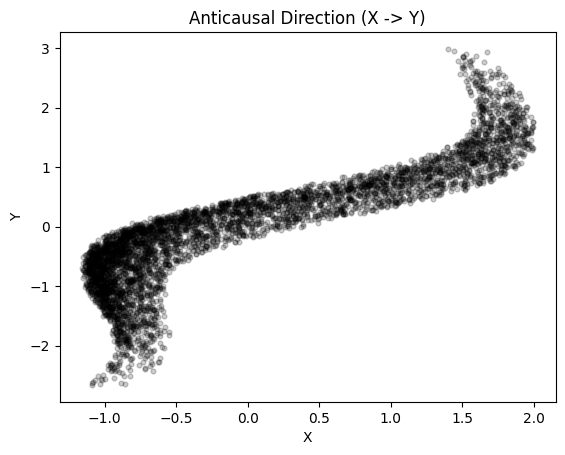

In [4]:
from plotting import plot_data, plot_flow, plot_velocity_grid

plot_data(x_data, y_data, alpha = 0.2, title = "Anticausal Direction (X -> Y)")
plt.xlabel("X")
plt.ylabel("Y")

Text(0, 0.5, 'X')

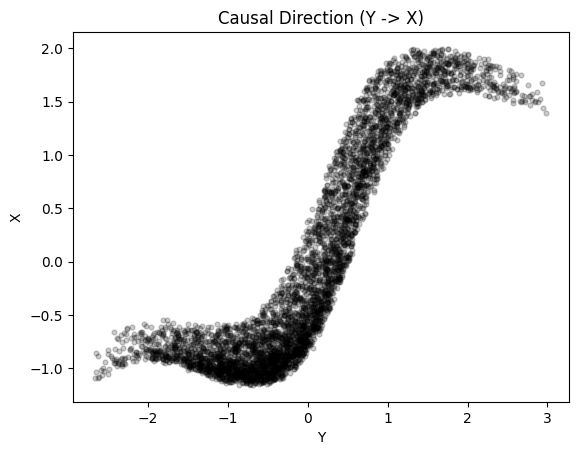

In [5]:
plot_data(y_data, x_data, alpha = 0.2, title = "Causal Direction (Y -> X)")
plt.xlabel("Y")
plt.ylabel("X")

The main function in the repository is `fit_sm_bd`, which does the following:
1. Estimates the score functions $s_x, s_y, s_{xy}$, here using the Stein estimator with the Gaussian kernel.
2. Using the same initialization parameters, fit the velocity model in the forward ($X \to Y$) and backward ($Y \to X$) direction.
3. Return the goodness-of-fit statistic for both directions, which by default (`gof="raw"`) evaluates `mean(abs(gof))`, where `gof` is the vector defined in Eqn. 18 of the paper. 

In [6]:
from training import fit_sm_bd

gof_fwd, gof_bwd, _, _, params_fwd, params_bwd, _, _  = fit_sm_bd(model = model,
                                                                                    params_init = params_init,
                                                                                    x_data = x_data,
                                                                                    y_data = y_data,
                                                                                    score = "stein",
                                                                                    score_kernel = "gauss")

print(f"Forward: GOF = {gof_fwd}")
print(f"Backward: GOF = {gof_bwd}")

Forward: GOF = 2.3662331104278564
Backward: GOF = 0.9812344312667847


Note the backward model (corresponding to the causal direction) fits the data better according to the GoF. We can look at the velocity field and the implied flow on top of the data, in both directions, to get a visual cue on what's happening:

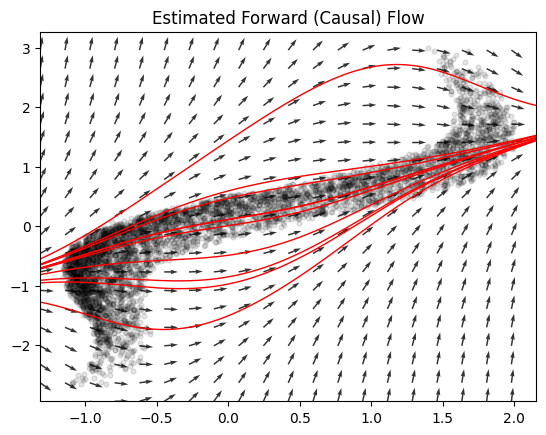

In [7]:
from mechanisms import mechanism_from_flow

class estimated_flow(mechanism_from_flow):

    def __init__(self, model, params):
        super().__init__(stiff = False)
        self.model = model
        self.params = params

    def velocity(self, y, x):
        return self.model(y, x, self.params)

est_fwd = estimated_flow(model, params_fwd)

plot_data(x_data, y_data)
plot_flow(est_fwd.flow,
           x_init = jax.random.choice(key=jax.random.PRNGKey(0), a = x_data, shape = (10,)),
           y_init = jax.random.choice(key=jax.random.PRNGKey(0), a = y_data, shape = (10,)), 
          color = "red")

plot_velocity_grid(jax.vmap(est_fwd.velocity), n_pts = 20, title = "Estimated Forward (Causal) Flow")

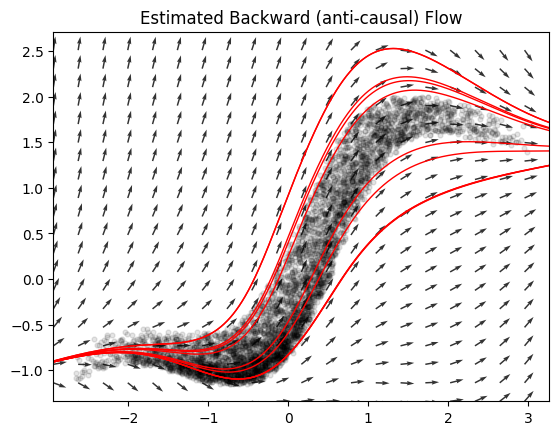

In [8]:
est_bwd = estimated_flow(model, params_bwd)

plot_data(y_data, x_data)
plot_flow(est_bwd.flow,
           x_init = jax.random.choice(key=jax.random.PRNGKey(0), a = x_data, shape = (10,)),
           y_init = jax.random.choice(key=jax.random.PRNGKey(0), a = y_data, shape = (10,)), 
          color = "red")

plot_velocity_grid(jax.vmap(est_bwd.velocity), n_pts = 20, title = "Estimated Backward (anti-causal) Flow")

Note the curves are obtained by numerically integrating the velocity field, taking 10 randomly sampled data points as initial conditions.

## Velocity Interpretation of SCMs

To start, let's look at reinterpreting existing SCMs. The `flow_from_mechanism` class computes the velocity of the model, given the forward and inverse mappings $f_x(\cdot), f_x(\cdot)^{-1}$. We can build the following class to sample neural networks that will parametrize either an ANM or LSNM (note we add a minimum scale factor of $0.1$ for the LSNM):

In [9]:
jax.config.update("jax_threefry_partitionable", False) # required as of v0.5.0 of jax 

In [10]:
from mechanisms import flow_from_mechanism

class nn_conditioner_mechanism(flow_from_mechanism):

    def __init__(self, mech = "anm", **kwargs):
        super().__init__()
        assert mech in ["anm", "lsnm"], "mech must be either 'anm' or 'lsnm'."
        self.mech = mech
        if mech == "anm":
            n_out = 1
        elif mech == "lsnm":
            n_out = 2
        self.build_nn_params(n_out, **kwargs)

    def build_nn_params(self, n_out, layers = 3, hidden_size = 64, seed = 0, init_weight = 0.4):
        params = {"w1": jax.random.normal(shape=(1, hidden_size), key=jax.random.PRNGKey(seed))*init_weight,
                    "b1": jax.random.normal(shape=(hidden_size), key=jax.random.PRNGKey(seed + 1))*init_weight}
        for i in range(layers - 2):
            params[f"w{i+2}"] = jax.random.normal(shape=(hidden_size, hidden_size), key=jax.random.PRNGKey(seed))*init_weight
            params[f"b{i+2}"] = jax.random.normal(shape=(hidden_size), key=jax.random.PRNGKey(seed + 1))*init_weight
            seed = seed + 2
        params[f"w{layers}"] = jax.random.normal(shape=(hidden_size, n_out), key=jax.random.PRNGKey(seed))*init_weight
        params[f"b{layers}"] = jax.random.normal(shape=(n_out), key=jax.random.PRNGKey(seed + 1))*init_weight
        self.params = params
        self.layers = layers

    def nn_conditioner(self, x):
        x = jnp.array(x)
        if x.ndim == 1:
            x = x[:, None]
        h = x
        for i in range(self.layers-1):
            h = jnp.dot(h, self.params[f"w{i+1}"]) + self.params[f"b{i+1}"]
            h = jax.nn.tanh(h)
        out = jnp.dot(h, self.params[f"w{self.layers}"]) + self.params[f"b{self.layers}"]
        return out

    def forward(self, x, e):
        """
        compute y = f_{x}(e)
        """
        cond = self.nn_conditioner(x)
        if self.mech == "anm":
            return (e + cond.squeeze()).squeeze()
        elif self.mech == "lsnm":
            mu, sigma = cond[:, 0], jnp.exp(cond[:, 1])
            return (mu + (sigma+0.1) * e).squeeze()

    def inverse(self, x, y):
        """
        compute e = f^{-1}_x(y) 
        """
        cond = self.nn_conditioner(x)
        if self.mech == "anm":
            return (y - cond.squeeze()).squeeze()
        elif self.mech == "lsnm":
            mu, sigma = cond[:, 0], jnp.exp(cond[:, 1])
            return ((y - mu)/(sigma+0.1)).squeeze()

This class has `velocity` and `flow` methods as follows. `flow` evaluates the mapping $f_{x'}(f_x^{-1}(y))$ (note this is the counterfactual prediction at $x'$, i.e., the causal curve), while `velocity` takes the derivative $d/dx' f_{x'}(f_x^{-1}(y))|_{x' = x}$. Recall that $v_{ANM}(y,x) = \dot m(x)$, so that it is constant over $y$:

In [11]:
anm = nn_conditioner_mechanism(mech = "anm", seed = 1)

print(f"ANM: velocity at v(0, 0) = {anm.velocity(0., 0.)}")  
print(f"ANM: velocity at v(1, 0) = {anm.velocity(1., 0.)}")  


ANM: velocity at v(0, 0) = 0.37607401609420776
ANM: velocity at v(1, 0) = 0.37607401609420776


On the other hand, $v_{LSNM}$ varies over both inputs:

In [12]:
lsnm = nn_conditioner_mechanism(mech = "lsnm", seed = 1)

print(f"LSNM: velocity at v(0, 0) = {lsnm.velocity(0., 0.)}")  ## v(y,x) 
print(f"LSNM: velocity at v(1, 0) = {lsnm.velocity(1., 0.)}")  ## v(y,x) 

LSNM: velocity at v(0, 0) = -6.8093109130859375
LSNM: velocity at v(1, 0) = -9.318517684936523


The `plotting` module includes some convenient functions to plot the velocity field over a given grid (for compatibility with learned vector fields, we have to pass a vmapped version to the plotting function). We also select some initial conditions to draw causal curves on top of these velocity fields ($x_0 = 0$, $y_0 \in \{0, \pm 1, \pm 2\}$).

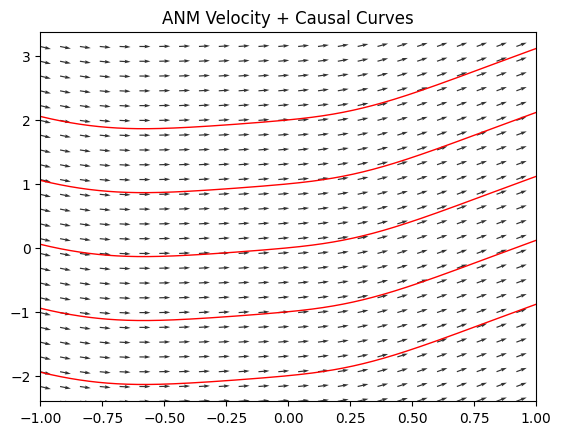

In [13]:
from plotting import plot_velocity_grid, plot_flow

xlim = (-1, 1)

plot_flow(anm.flow, 
          x_init = jnp.zeros((5,)),
          y_init = jnp.array([-2., -1., 0., 1., 2.]),
          xlim = xlim,
          n_pts = 1000)
plot_velocity_grid(jax.vmap(anm.velocity), n_pts = 25, title = "ANM Velocity + Causal Curves")

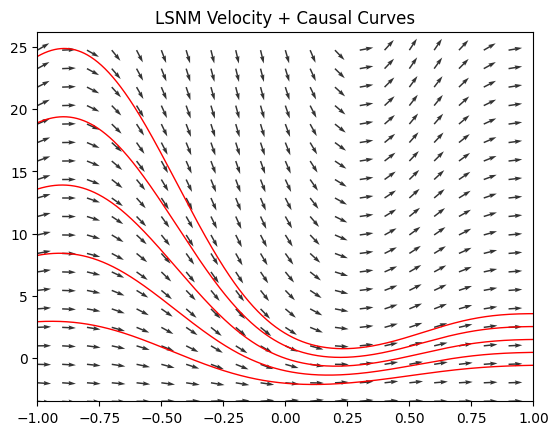

In [14]:
plot_flow(lsnm.flow, 
          x_init = jnp.zeros((5,)),
          y_init = jnp.array([-2., -1., 0., 1., 2.]),
          n_pts = 1000, xlim=xlim)
plot_velocity_grid(jax.vmap(lsnm.velocity), xlim = xlim, n_pts = 20, title = "LSNM Velocity + Causal Curves")

Just to sanity check, we can also numerically integrate the velocity function to recover the mechanism, up to numerical error. The class `mechanism_from_flow` takes a velocity function $v(y,x)$, and implements numerical integration to compute the `forward`, `inverse`, and `flow` methods. 

In [15]:
from mechanisms import mechanism_from_flow

class velocity_flow(mechanism_from_flow):

    def __init__(self, mech):
        super().__init__()
        self.mech = mech

    def velocity(self, y, x):
        if self.mech == "anm":
            return anm.velocity(y, x)
        elif self.mech == "lsnm":
            return lsnm.velocity(y, x)

We can check the numerically integrated counterparts against the closed form version: 

In [16]:
anm_v = velocity_flow("anm")
lsnm_v = velocity_flow("lsnm")

print(f"ANM: phi(0, 2)(0) = {anm.flow(2., 0., 0.)}, phi(0, 2)(0)(integrated) = {anm_v.flow(2., 0., 0.).squeeze()}")

print(f"LSNM: phi(0, 2)(0) = {lsnm.flow(2., 0., 0.)}, phi(0, 2)(0)(integrated) = {lsnm_v.flow(2., 0., 0.).squeeze()}")

ANM: phi(0, 2)(0) = 1.6155989170074463, phi(0, 2)(0)(integrated) = 1.615592360496521
LSNM: phi(0, 2)(0) = 1.7963604927062988, phi(0, 2)(0)(integrated) = 1.796355962753296


We can also plot the flow to confirm: 

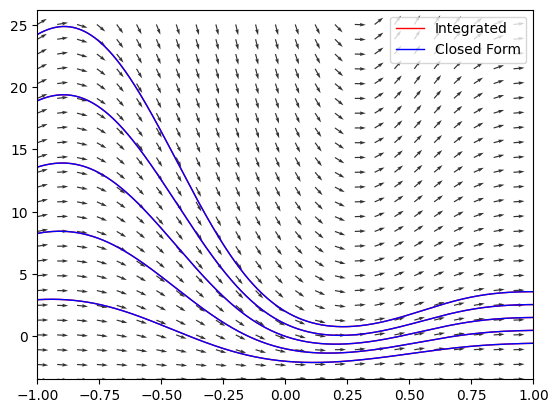

In [17]:
lsnm_v = velocity_flow("lsnm")
plot_flow(lsnm_v.flow, 
          x_init = jnp.zeros((5,)),
          y_init = jnp.array([-2., -1., 0., 1., 2.]),
          n_pts = 1000, xlim=xlim)
plot_flow(lsnm.flow,
          x_init = jnp.zeros((5,)),
          y_init = jnp.array([-2., -1., 0., 1., 2.]),
          n_pts = 1000, xlim=xlim,
          color = "blue")
plot_velocity_grid(jax.vmap(lsnm_v.velocity), xlim = xlim, n_pts = 25)


plt.plot([], [], color='red', linewidth=1, label = "Integrated")
plt.plot([], [], color='blue', linewidth=1, label = "Closed Form")
plt.legend()

## LSNM Velocities in the well-specified setting

Let's generate some data from the LSNM above:

In [18]:
N_DATA = 1000
DATA_SEED = 0

In [19]:
## we scale x just to make the mechanism better behaved--the standardization still makes x a standard gaussian.
x_data = jax.random.normal(shape = (N_DATA,), key = jax.random.PRNGKey(DATA_SEED))
noise = jax.random.normal(shape = (N_DATA,), key = jax.random.PRNGKey(DATA_SEED + 1))
y_data = lsnm.forward(x_data, noise)

We can plot the data alongside the velocity and a few randomly sampled curves.

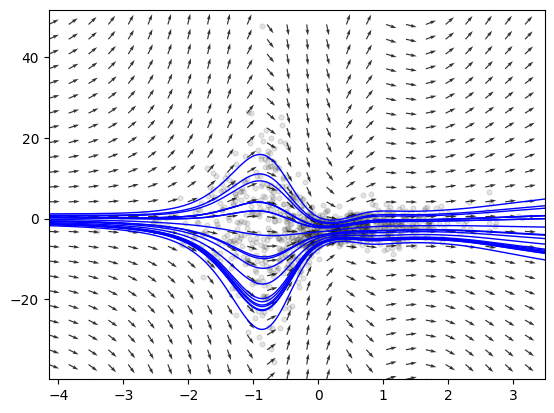

In [20]:
from plotting import plot_data
plot_data(x_data, y_data)
plot_flow(lsnm.flow,
           x_init = jax.random.choice(key=jax.random.PRNGKey(0), a = x_data, shape = (20,)),
           y_init = jax.random.choice(key=jax.random.PRNGKey(0), a = y_data, shape = (20,)), 
          n_pts = 1000,
          color = "blue")
plot_velocity_grid(jax.vmap(lsnm_v.velocity), n_pts = 25)



We will standardize the data for model fitting. Note the normalized velocity can be computed as follows:
$$
y' = \frac{y - \mu_y}{\sigma_y}, \quad  x' = \frac{x - \mu_x}{\sigma_x} \quad \quad \frac{dy'}{dx'} = \frac{dy'}{dy} \frac{dy}{dx} \frac{dx'}{dx}^{-1} = \frac{\sigma_x}{\sigma_y} \frac{dy}{dx},
$$
where note $dy/dx$ should be computed on the original scale, that is, $dy/dx = v(y' \sigma_y, x' \sigma_x) = v(y,x)$.

In [21]:
from utils import standardize_data

dat = jnp.concat((x_data[:, None], y_data[:, None]), axis = -1)


dat, dat_mean, dat_std = standardize_data(dat, return_statistics = True, trim_outliers = 0) 
x_data, x_data_mean, x_data_std = dat[:,0], dat_mean[0], dat_std[0]
y_data, y_data_mean, y_data_std = dat[:,1], dat_mean[1], dat_std[1]

## the statistics can be passed to the lsnm object to also standardize the flow and velocity:

lsnm.set_normalization_statistics(x_data_mean, x_data_std, y_data_mean, y_data_std)

print(lsnm.x_mean, lsnm.x_std, lsnm.y_mean, lsnm.y_std)


-0.0056812027 0.97692525 -2.295493 7.0642204


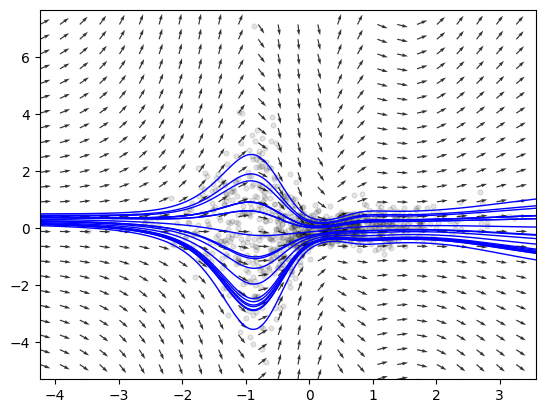

In [22]:
plot_data(x_data, y_data)
plot_flow(lsnm.flow_normalized,
           x_init = jax.random.choice(key=jax.random.PRNGKey(0), a = x_data, shape = (20,)),
           y_init = jax.random.choice(key=jax.random.PRNGKey(0), a = y_data, shape = (20,)), 
          n_pts = 1000,
          color = "blue")
plot_velocity_grid(jax.vmap(lsnm.velocity_normalized), n_pts = 25)

Let's try to fit this with a velocity-paramterized LSNM.

In [23]:
from models import lsnm_model

model = lsnm_model()
params_init = model.params_init(seed = 444, init_weight = 0.2)

gof_fwd, gof_bwd, complexity_fwd, complexity_bwd, params_fwd, params_bwd, _, _ = fit_sm_bd(model = model,
                                                                                    params_init = params_init,
                                                                                    x_data = x_data,
                                                                                    y_data = y_data,
                                                                                    score = "stein",
                                                                                    score_kernel = "gauss",
                                                                                    n_steps = 1000)

We can look at the estimated velocity and implied curves compared to the data (and ground truth):

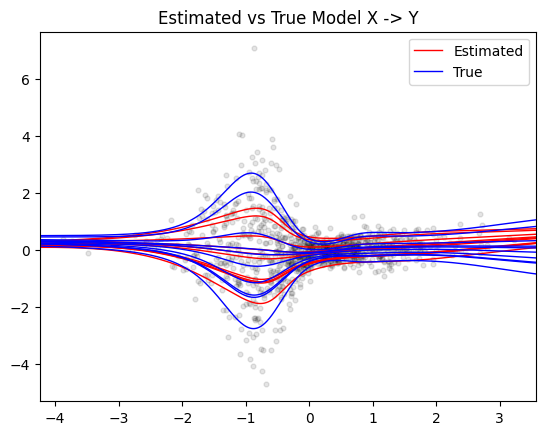

In [24]:
class estimated_flow(mechanism_from_flow):

    def __init__(self, model, params):
        super().__init__(stiff = True)
        self.model = model
        self.params = params

    def velocity(self, y, x):
        return self.model(y, x, self.params)

est_fwd = estimated_flow(model, params_fwd)

plot_data(x_data, y_data)
plot_flow(est_fwd.flow,
           x_init = jax.random.choice(key=jax.random.PRNGKey(0), a = x_data, shape = (10,)),
           y_init = jax.random.choice(key=jax.random.PRNGKey(0), a = y_data, shape = (10,)), 
          color = "red")

plot_flow(lsnm.flow_normalized,
           x_init = jax.random.choice(key=jax.random.PRNGKey(0), a = x_data, shape = (10,)),
           y_init = jax.random.choice(key=jax.random.PRNGKey(0), a = y_data, shape = (10,)), 
          color = "blue", title = "Estimated vs True Model X -> Y")

plt.plot([], [], color='red', linewidth=1, label = "Estimated")
plt.plot([], [], color='blue', linewidth=1, label = "True")
plt.legend()




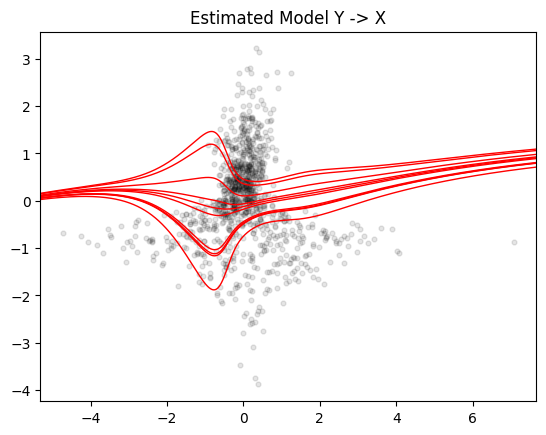

In [25]:
est_bwd = estimated_flow(model, params_bwd)

plot_data(y_data, x_data)
plot_flow(est_fwd.flow,
           x_init = jax.random.choice(key=jax.random.PRNGKey(0), a = x_data, shape = (10,)),
           y_init = jax.random.choice(key=jax.random.PRNGKey(0), a = y_data, shape = (10,)), 
          color = "red", title = "Estimated Model Y -> X")

The fitted curves capture the data reasonably well in the true causal direction. Even though the model class is well-specified, it misses some of the tail behaviour of the true LSNM--this is unlikely to be a failure of the model but rather of the score estimation. Since the data are generated by Gaussians here, it is actually quite simple to get the ground truth scores $s_x, s_{xy}$ which we can also use to estimate the velocity. In particular, let $Y = f_X(\epsilon)$ with $X, \epsilon$ independent Gaussians.
If $p(x)$ is a standard Gaussian density, we have $\nabla_x \log p(x) = -x$, and, via the change of variables, $p(y \mid x) = p_\epsilon(f^{-1}_x(y)) \partial_y {f^{-1}_x}(y)$. We can compute the joint score as follows:
$$
\nabla \log p(x,y) = \nabla \log p(x) + \log p(y|x) = \nabla \log p(x) + \log p_\epsilon(f^{-1}_x(y)) + \log \partial_y f^{-1}_x(y)
$$
The x-component is as follows:
$$
\partial_x \log p(x,y) = \partial_x \log p(x) + \partial_x \log \partial_y f^{-1}_x(y) = -x +  \partial_x \log \partial_y {f^{-1}_x}(y) \\
= -x + \frac{\partial_{xy} f^{-1}_x(y)}{\partial_y {f^{-1}_x}(y)}.
$$
The y-component is similar. Let $\epsilon = f^{-1}_x(y)$, and note that $\partial_\epsilon \log  p_\epsilon(\epsilon) = - \epsilon$ since it is also Gaussian. 
$$
\partial_y \log p(x,y) = \partial_y \log p_\epsilon(f^{-1}_x(y)) + \partial_y \log \partial_y{f^{-1}_x}(y) = \partial_\epsilon \log p_\epsilon(\epsilon) \partial_y f^{-1}_x(y) + \partial_y \log \partial_y{f^{-1}_x}(y) \\
= -\epsilon  \partial_y f^{-1}_x(y) + \frac{\partial^2_y f^{-1}_x(y)}{\partial_y f^{-1}_x(y)}
$$

In [26]:
def gaussian_score_oracle(x, y, model):
    """
    Computes the ground truth sx, sxy given gaussian noise and mechanism "model". 
    """
    e = model.inverse_normalized(x, y)
    df = jax.vmap(jax.grad(model.inverse_normalized, (0, 1))) ## returns tuple (df-1/dx, df-1/dy)
    dfdy = jax.grad(model.inverse_normalized, 1)
    dfdxdy = jax.vmap(jax.grad(dfdy, (0,1))) ## returns tuple (d^2f-1/dxdy, d^2f-1/dy^2)

    dx_data, dy_data = df(x, y)
    dxdy_data, dydy_data = dfdxdy(x, y)

    sx = -x_data ## std. gaussian score 
    sxyx = -x_data + (-e)*(dx_data) + dxdy_data/dy_data
    sxyy = - e * dy_data + dydy_data/dy_data

    sxy = jnp.stack((sxyx, sxyy), axis = -1)

    return sx, sxy

sx_data, sxy_data = gaussian_score_oracle(x_data, y_data, lsnm)
sy_data = jnp.ones_like(sx_data) ## the function expects sy as well, we will just give it a dummy here

_, _, _, _, params_fwd_oracle, _, _, _ = fit_sm_bd(model = model,
                                                        params_init = params_init,
                                                        x_data = x_data,
                                                        y_data = y_data,
                                                        sx_data = sx_data,
                                                        sy_data = sy_data,
                                                        sxy_data = sxy_data,
                                                        n_steps=1000)

est_fwd_oracle = estimated_flow(model, params_fwd_oracle)

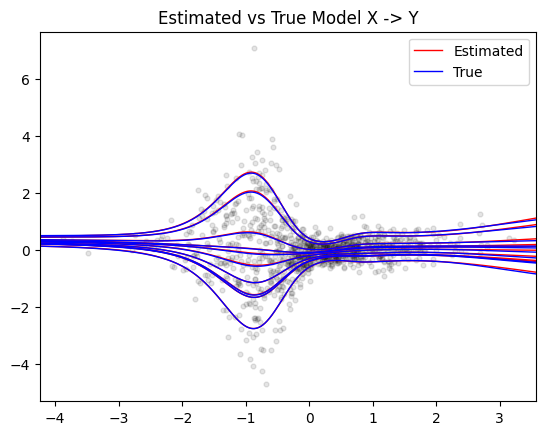

In [27]:
plot_data(x_data, y_data)
plot_flow(est_fwd_oracle.flow,
           x_init = jax.random.choice(key=jax.random.PRNGKey(0), a = x_data, shape = (10,)),
           y_init = jax.random.choice(key=jax.random.PRNGKey(0), a = y_data, shape = (10,)), 
          color = "red")

plot_flow(lsnm.flow_normalized,
           x_init = jax.random.choice(key=jax.random.PRNGKey(0), a = x_data, shape = (10,)),
           y_init = jax.random.choice(key=jax.random.PRNGKey(0), a = y_data, shape = (10,)), 
          color = "blue", title = "Estimated vs True Model X -> Y")

plt.plot([], [], color='red', linewidth=1, label = "Estimated")
plt.plot([], [], color='blue', linewidth=1, label = "True")
plt.legend()

Of course this is an unrealistic setting, but it's pretty interesting that the score contains enough information to fully recover the causal curves theoretically. 